In [1]:
import numpy as np
import pandas as pd
import os.path
from random import randint

# -*- coding: utf-8 -*-
"""
### NOTES
This file is an example of what your code should look like. It is written in Python 3.6.
To know more about the expectations, please refer to the guidelines.
"""

#####
# DATA IMPORT
#####

# Where data is located
movies_file = './data/movies.csv'
users_file = './data/users.csv'
ratings_file = './data/ratings.csv'
predictions_file = './data/predictions.csv'
submission_file = './data/submission.csv'

# Read the data using pandas
movies_description = pd.read_csv(movies_file, delimiter=';', dtype={'movieID': 'int', 'year': 'int', 'movie': 'str'},
                                 names=['movieID', 'year', 'movie'])
users_description = pd.read_csv(users_file, delimiter=';',
                                dtype={'userID': 'int', 'gender': 'str', 'age': 'int', 'profession': 'int'},
                                names=['userID', 'gender', 'age', 'profession'])
ratings_description = pd.read_csv(ratings_file, delimiter=';',
                                  dtype={'userID': 'int', 'movieID': 'int', 'rating': 'int'},
                                  names=['userID', 'movieID', 'rating'])
predictions_description = pd.read_csv(predictions_file, delimiter=';', names=['userID', 'movieID'], header=None)

utility_matrix: pd.DataFrame = \
        ratings_description.pivot(index='userID', columns='movieID', values='rating').T
utility_matrix

userID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
##### Construct Utility Matrix ####### 
R = np.zeros((len(movies_description), len(users_description)))

for user, movie, rating in ratings_description.values:
    R[movie-1, user-1] = rating

R[R==0] = np.nan
print(f"Shape of Utility matrix is (movies, users): {R.shape}")

Shape of Utility matrix is (movies, users): (3706, 6040)


In [7]:
#### LATENT FACTORS HYPERPARAMETERS ####
from tqdm import tqdm_notebook as tqdm

EPOCHS = 1000
LEARNING_RATE = 0.05 # == nu
K = 2 # number of factors to work with.

np.random.seed(42)
Q = np.random.uniform(-1, 1, (R.shape[0], K))
P = np.random.uniform(-1, 1, (K, R.shape[1]))
div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

objectives = []

for epoch in tqdm(range(1000)):
    R_pred = np.matmul(Q,P)
    curr_error = np.nan_to_num(R - R_pred, 0)
    Q_update = np.zeros(Q.shape)
    for i in range(len(Q_update)):
        for curr_k in range(K):
            Q_delta =(-2 * np.dot(P[curr_k, :], curr_error[i]))/np.isnan(R[i]).sum()
            Q_update[i, curr_k] = LEARNING_RATE * Q_delta

    P_update = np.zeros(P.shape)
    for i in range(P_update.shape[1]):
        for curr_k in range(K):
            P_delta =(-2 * np.dot(Q[:, curr_k], curr_error[:, i]))/np.isnan(R[:, i]).sum()
            P_update[curr_k, i] = LEARNING_RATE * P_delta

    Q -= Q_update
    P -= P_update
    
    RMSE_i = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
    objectives.append([epoch, RMSE_i])


RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Starting RMSE: 3.781830053581588


<ipython-input-7-3fb91e8b325e>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1000)):



Final RMSE: 0.927614548906496


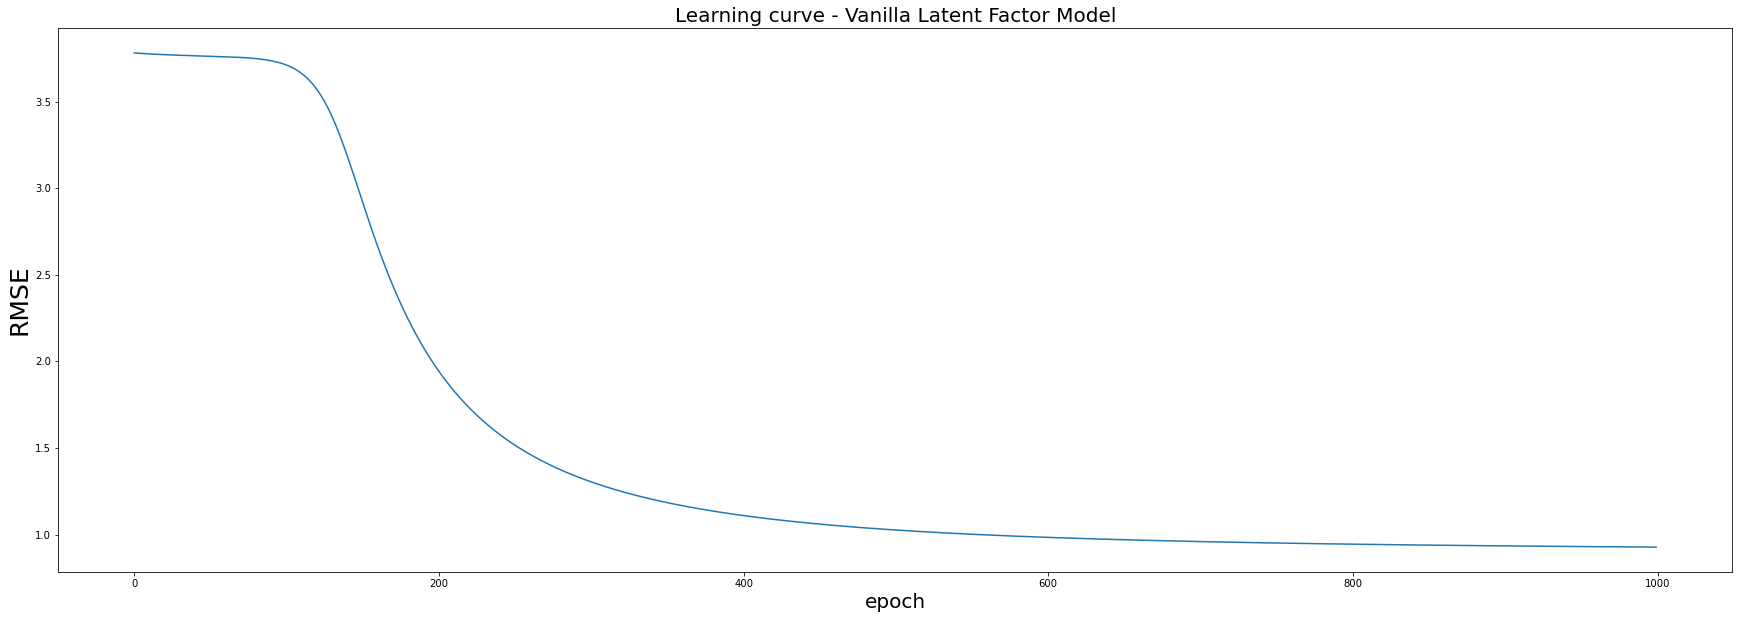

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.title("Learning curve - Vanilla Latent Factor Model", fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("RMSE", fontsize=25)
plt.plot(np.array(objectives)[:, 1])
plt.savefig("figures/vanilla-latent-factor.png")

In [16]:
#### LATENT FACTORS WITH REGULARIZATION ####
#### LATENT FACTORS HYPERPARAMETERS ####
from tqdm import tqdm_notebook as tqdm

EPOCHS = 1000
LEARNING_RATE = 0.05 # == nu
LAMBDA = 0.01
K = 2 # number of factors to work with.

np.random.seed(42)
Q = np.random.uniform(-1, 1, (R.shape[0], K))
P = np.random.uniform(-1, 1, (K, R.shape[1]))
div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

objectives = []

for epoch in tqdm(range(1000)):
    R_pred = np.matmul(Q,P)
    curr_error = np.nan_to_num(R - R_pred, 0)
    Q_update = np.zeros(Q.shape)
    for i in range(len(Q_update)):
        for curr_k in range(K):
            Q_delta =(-2 * np.dot(P[curr_k, :], curr_error[i]))/np.isnan(R[i]).sum()
            Q_update[i, curr_k] = LEARNING_RATE * (Q_delta + LAMBDA*Q[i, curr_k])

    P_update = np.zeros(P.shape)
    for i in range(P_update.shape[1]):
        for curr_k in range(K):
            P_delta =(-2 * np.dot(Q[:, curr_k], curr_error[:, i]))/np.isnan(R[:, i]).sum()
            P_update[curr_k, i] = LEARNING_RATE * (P_delta + LAMBDA*P[curr_k, i])

    Q -= Q_update
    P -= P_update
    
    RMSE_i = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
    print(f"RMSE {epoch}: {RMSE_i}")
    objectives.append([epoch, RMSE_i])


RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Starting RMSE: 3.781830053581588


<ipython-input-16-3f46e573ee58>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1000)):


RMSE 0: 3.7810569863061056
RMSE 1: 3.7803143482127624
RMSE 2: 3.779600254864564
RMSE 3: 3.7789129704709286
RMSE 4: 3.778250893695214
RMSE 5: 3.777612544956513
RMSE 6: 3.7769965550515123
RMSE 7: 3.7764016549438972
RMSE 8: 3.775826666587716
RMSE 9: 3.7752704946672684
RMSE 10: 3.7747321191502476
RMSE 11: 3.7742105885634096
RMSE 12: 3.7737050139101416
RMSE 13: 3.7732145631594074
RMSE 14: 3.7727384562430437
RMSE 15: 3.7722759605057528
RMSE 16: 3.7718263865583967
RMSE 17: 3.7713890844906053
RMSE 18: 3.770963440403323
RMSE 19: 3.770548873226374
RMSE 20: 3.7701448317896378
RMSE 21: 3.7697507921195914
RMSE 22: 3.769366254935952
RMSE 23: 3.7689907433255794
RMSE 24: 3.7686238005728576
RMSE 25: 3.7682649881278585
RMSE 26: 3.7679138836952064
RMSE 27: 3.767570079427781
RMSE 28: 3.767233180211209
RMSE 29: 3.7669028020254043
RMSE 30: 3.7665785703712467
RMSE 31: 3.766260118750528
RMSE 32: 3.765947087188441
RMSE 33: 3.7656391207883746
RMSE 34: 3.7653358683090308
RMSE 35: 3.7650369807546875
RMSE 36: 3.76

RMSE 290: 1.3591045088586962
RMSE 291: 1.3557129118222715
RMSE 292: 1.3523605188838517
RMSE 293: 1.3490467232823815
RMSE 294: 1.3457709300497775
RMSE 295: 1.342532555739377
RMSE 296: 1.339331028161372
RMSE 297: 1.336165786125044
RMSE 298: 1.333036279187646
RMSE 299: 1.3299419674097053
RMSE 300: 1.3268823211166212
RMSE 301: 1.3238568206663381
RMSE 302: 1.3208649562229728
RMSE 303: 1.3179062275362
RMSE 304: 1.3149801437262567
RMSE 305: 1.312086223074425
RMSE 306: 1.309223992818795
RMSE 307: 1.306392988955226
RMSE 308: 1.3035927560433156
RMSE 309: 1.30082284701728
RMSE 310: 1.2980828230015713
RMSE 311: 1.2953722531311314
RMSE 312: 1.2926907143761444
RMSE 313: 1.2900377913711794
RMSE 314: 1.2874130762485765
RMSE 315: 1.2848161684759838
RMSE 316: 1.2822466746979309
RMSE 317: 1.279704208581327
RMSE 318: 1.2771883906647579
RMSE 319: 1.2746988482115058
RMSE 320: 1.2722352150662015
RMSE 321: 1.269797131514943
RMSE 322: 1.2673842441488905
RMSE 323: 1.2649962057311337
RMSE 324: 1.262632675066859


RMSE 576: 1.0190555055352626
RMSE 577: 1.0186999756985025
RMSE 578: 1.0183464533090778
RMSE 579: 1.0179949235977894
RMSE 580: 1.017645371928985
RMSE 581: 1.0172977837991253
RMSE 582: 1.0169521448353587
RMSE 583: 1.016608440794124
RMSE 584: 1.0162666575597674
RMSE 585: 1.0159267811431685
RMSE 586: 1.0155887976804001
RMSE 587: 1.0152526934313884
RMSE 588: 1.0149184547785972
RMSE 589: 1.0145860682257313
RMSE 590: 1.0142555203964472
RMSE 591: 1.0139267980330913
RMSE 592: 1.0135998879954375
RMSE 593: 1.0132747772594606
RMSE 594: 1.0129514529161057
RMSE 595: 1.0126299021700846
RMSE 596: 1.0123101123386886
RMSE 597: 1.0119920708505965
RMSE 598: 1.0116757652447248
RMSE 599: 1.0113611831690712
RMSE 600: 1.0110483123795848
RMSE 601: 1.0107371407390344
RMSE 602: 1.0104276562159116
RMSE 603: 1.010119846883326
RMSE 604: 1.0098137009179349
RMSE 605: 1.009509206598861
RMSE 606: 1.0092063523066515
RMSE 607: 1.0089051265222189
RMSE 608: 1.008605517825825
RMSE 609: 1.0083075148960512
RMSE 610: 1.0080111

RMSE 861: 0.9648583474776129
RMSE 862: 0.9647623079886576
RMSE 863: 0.964666627712839
RMSE 864: 0.9645713048544006
RMSE 865: 0.9644763376284827
RMSE 866: 0.964381724261043
RMSE 867: 0.9642874629887793
RMSE 868: 0.9641935520590501
RMSE 869: 0.9640999897297982
RMSE 870: 0.9640067742694741
RMSE 871: 0.9639139039569661
RMSE 872: 0.9638213770815146
RMSE 873: 0.9637291919426465
RMSE 874: 0.9636373468500973
RMSE 875: 0.963545840123738
RMSE 876: 0.9634546700935102
RMSE 877: 0.9633638350993411
RMSE 878: 0.9632733334910838
RMSE 879: 0.963183163628439
RMSE 880: 0.9630933238808866
RMSE 881: 0.9630038126276207
RMSE 882: 0.9629146282574766
RMSE 883: 0.9628257691688598
RMSE 884: 0.9627372337696845
RMSE 885: 0.9626490204773023
RMSE 886: 0.9625611277184327
RMSE 887: 0.9624735539291106
RMSE 888: 0.9623862975545986
RMSE 889: 0.9622993570493386
RMSE 890: 0.9622127308768834
RMSE 891: 0.9621264175098335
RMSE 892: 0.9620404154297637
RMSE 893: 0.9619547231271763
RMSE 894: 0.9618693391014292
RMSE 895: 0.961784

In [6]:
#### CREATE SUBMISSION ####
submission = []
for i, [user,movie] in enumerate(predictions_description.values):
    submission.append([i+1, R_pred[movie-1,user-1]])

submission_df = pd.DataFrame(submission, columns=["Id", "# Rating"])
submission_df.to_csv("data/submission.csv", index=False)

[[1, 3.474430655182154],
 [2, 2.261235162482041],
 [3, 3.5400326311644896],
 [4, 4.092255007716797],
 [5, 3.0139332735093665],
 [6, 1.6816272485662942],
 [7, 3.959154112699957],
 [8, 4.2130823613515345],
 [9, 3.3925228566412367],
 [10, 4.3078897450218125]]